In [1]:
from sklearn.metrics import roc_curve, auc
from scipy import spatial
import scipy.stats as stats
import numpy as np
import pandas as pd
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
def save_obj(obj, name):
    print('Saving object', name)
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    print('Loading object', name)
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
def find_thr_far(far, value):
    return np.argmin(np.abs(value - far))

In [4]:
def get_performance(identical, scores):
    far, tpr, thresholds = roc_curve(np.array(identical), np.array(scores))
    frr = 1 - tpr
    idx_eer = np.argmin(np.abs(far - frr))
    idx_far1 = find_thr_far(far, 0.01)
    return {'tpr': tpr, 'far': far, 
            'eer': {'thr': thresholds[idx_eer], 'far': far[idx_eer], 'frr': frr[idx_eer]}, 
            'far1': {'thr': thresholds[idx_far1], 'far': far[idx_far1], 'frr': frr[idx_far1]}}

In [5]:
def moving_average(data_set, periods=5):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

In [6]:
model_id = '_xvector'

In [7]:
scores = load_obj('./dl_master_voices/real_comparisons' + model_id)

Loading object ./dl_master_voices/real_comparisons_xvector


In [8]:
policies = ['raw', 'any10', 'avg10']

In [9]:
comp_types = ['m', 'f']

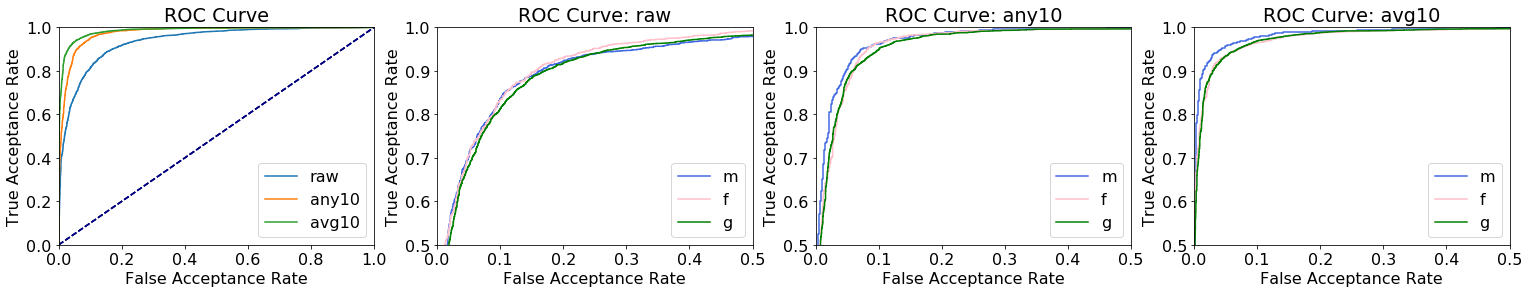

In [10]:
plt.figure(figsize=(26, 4))
plt.rcParams.update({'font.size': 16})

plt.subplot(1,4,1)
for i, policy in enumerate(policies):
    i = scores[policy]['mm_identical'] + scores[policy]['mf_identical'] + scores[policy]['fm_identical'] + scores[policy]['ff_identical']
    s = scores[policy]['mm_scores'] + scores[policy]['mf_scores'] + scores[policy]['fm_scores'] + scores[policy]['ff_scores']
    metrics = get_performance(i, s)
    plt.plot(metrics['far'], metrics['tpr'], label=policy)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Acceptance Rate')
    plt.ylabel('True Acceptance Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
for i, policy in enumerate(policies):
    plt.subplot(1,4,i+2)
    for comp_type in comp_types:
        i = scores[policy][comp_type + 'm_identical'] + scores[policy][comp_type + 'f_identical']
        s = scores[policy][comp_type + 'm_scores'] + scores[policy][comp_type + 'f_scores']
        metrics = get_performance(i, s)
        plt.plot(metrics['far'], metrics['tpr'], label=comp_type, color=('pink' if comp_type == 'f' else 'royalblue'))
    i = scores[policy]['mm_identical'] + scores[policy]['mf_identical'] + scores[policy]['fm_identical'] + scores[policy]['ff_identical']
    s = scores[policy]['mm_scores'] + scores[policy]['mf_scores'] + scores[policy]['fm_scores'] + scores[policy]['ff_scores']
    metrics = get_performance(i, s)
    plt.plot(metrics['far'], metrics['tpr'], label='g', color='green')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 0.5])
    plt.ylim([0.5, 1.0])
    plt.xlabel('False Acceptance Rate')
    plt.ylabel('True Acceptance Rate')
    plt.title('ROC Curve: ' + policy)
    plt.legend(loc="lower right")
    
plt.savefig('roc_curves' + model_id + '.pdf')
plt.show()

In [11]:
results = {}
for policy in policies:
    i = scores[policy]['mm_identical'] + scores[policy]['mf_identical'] + scores[policy]['fm_identical'] + scores[policy]['ff_identical']
    s = scores[policy]['mm_scores'] + scores[policy]['mf_scores'] + scores[policy]['fm_scores'] + scores[policy]['ff_scores']
    metrics = get_performance(i, s)
    results[policy] = metrics
    print('POLICY:', policy, '\t', 
          'FAR@EER:', round(metrics['eer']['far'],3), ' \t', 
          'FRR@EER:', round(metrics['eer']['frr'],3), '\t', 
          'THR@EER:', round(metrics['eer']['thr'],3), '\t',
          'FAR@FAR1:', round(metrics['far1']['far'],3), '\t', 
          'FRR@FAR1:', round(metrics['far1']['frr'],3), '\t',
          'THR@FAR1:', round(metrics['far1']['thr'],3))

POLICY: raw 	 FAR@EER: 0.136  	 FRR@EER: 0.135 	 THR@EER: 0.98 	 FAR@FAR1: 0.01 	 FRR@FAR1: 0.587 	 THR@FAR1: 0.987
POLICY: any10 	 FAR@EER: 0.076  	 FRR@EER: 0.077 	 THR@EER: 0.986 	 FAR@FAR1: 0.01 	 FRR@FAR1: 0.462 	 THR@FAR1: 0.991
POLICY: avg10 	 FAR@EER: 0.058  	 FRR@EER: 0.057 	 THR@EER: 0.987 	 FAR@FAR1: 0.01 	 FRR@FAR1: 0.246 	 THR@FAR1: 0.99


### Master Voice Comparisons

In [15]:
scores = load_obj('./dl_master_voices/mv_comparisons' + model_id)

Loading object ./dl_master_voices/mv_comparisons_xvector


In [26]:
print('-', '\t\t\t', 'M_EER', '\t', 'F_EER', '', 'M_FAR1', '', 'F_FAR1')
for index, setup in enumerate(list(scores.keys())):
    policy = setup.split('_')[-1]
    if 'raw' in setup:
        m_scores = scores[setup]['m']
        f_scores = scores[setup]['f']
        eer_thr = results['raw']['eer']['thr']
        far1_thr = results['raw']['far1']['thr']
        m_eer_far = np.sum([1 for s in m_scores if s >= eer_thr]) / len(m_scores)
        m_far1_far = np.sum([1 for s in m_scores if s >= far1_thr]) / len(m_scores)
        f_eer_far = np.sum([1 for s in f_scores if s >= eer_thr]) / len(f_scores)
        f_far1_far = np.sum([1 for s in f_scores if s >= far1_thr]) / len(f_scores)
        print(index, setup, '\t', round(m_eer_far,3), '\t', round(f_eer_far,3), '\t', round(m_far1_far,3), '\t', round(f_far1_far,3))

- 			 M_EER 	 F_EER  M_FAR1  F_FAR1
0 gan_m-m_sv_raw 	 0.449 	 0.232 	 0.082 	 0.029
4 gan_mf-m_mv_raw 	 0.433 	 0.334 	 0.075 	 0.042
6 gan_f-f_sv_raw 	 0.368 	 0.438 	 0.069 	 0.086
8 gan_mf-f_mv_raw 	 0.256 	 0.214 	 0.018 	 0.024
10 gan_mf-f_sv_raw 	 0.423 	 0.317 	 0.051 	 0.048
11 gan_m-m_mv_raw 	 0.441 	 0.243 	 0.076 	 0.034
15 real_f-f_sv_raw 	 0.042 	 0.333 	 0.001 	 0.047
17 real_m-m_sv_raw 	 0.12 	 0.033 	 0.002 	 0.001
20 real_f-f_mv_raw 	 0.049 	 0.32 	 0.002 	 0.041
21 real_m-m_mv_raw 	 0.103 	 0.03 	 0.004 	 0.0
26 gan_f-f_mv_raw 	 0.339 	 0.424 	 0.051 	 0.081
28 gan_mf-m_sv_raw 	 0.372 	 0.394 	 0.046 	 0.066


### Impersonation Rate Comparison

In [14]:
scores = load_obj('./dl_master_voices/mv_impersonations' + model_id) # set-policy -> mv file -> m/f

Loading object ./dl_master_voices/mv_impersonations_xvector


In [17]:
for index, setup in enumerate(list(scores.keys())):
    policy = setup.split('_')[-1]
    if policy == 'raw':
        m_eer_imp_rates = []
        m_far1_imp_rates = []
        f_eer_imp_rates = []
        f_far1_imp_rates = []
        print('-------------------------------------------')
        print(index, setup)
        print('-------------------------------------------')
        print('\t', 'M_EER', '\t', 'F_EER', '', 'M_FAR1', '', 'F_FAR1')
        for mv_file in list(scores[setup].keys()):
            mv_index = mv_file.split('.')[0].split('_')[-1]
            m_scores = scores[setup][mv_file]['m']
            f_scores = scores[setup][mv_file]['f']
            eer_thr = results[policy]['eer']['thr']
            far1_thr = results[policy]['far1']['thr']
            m_eer_imp_rates.append(np.sum([1 for s in m_scores if s >= eer_thr]) / len(m_scores))
            m_far1_imp_rates.append(np.sum([1 for s in m_scores if s >= far1_thr]) / len(m_scores))
            f_eer_imp_rates.append(np.sum([1 for s in f_scores if s >= eer_thr]) / len(f_scores))
            f_far1_imp_rates.append(np.sum([1 for s in f_scores if s >= far1_thr]) / len(f_scores))
            print('--', mv_index, '\t', 
                  round(np.sum([1 for s in m_scores if s >= eer_thr]) / len(m_scores),3), '\t', 
                  round(np.sum([1 for s in f_scores if s >= eer_thr]) / len(f_scores),3), '\t', 
                  round(np.sum([1 for s in m_scores if s >= far1_thr]) / len(m_scores),3), '\t', 
                  round(np.sum([1 for s in f_scores if s >= far1_thr]) / len(f_scores),3))
        avg_m_eer = np.mean(m_eer_imp_rates)
        avg_f_eer = np.mean(f_eer_imp_rates)
        avg_m_far1 = np.mean(m_far1_imp_rates)
        avg_f_far1 = np.mean(f_far1_imp_rates)
        print('-- TOTAL', round(avg_m_eer,3), '\t', round(avg_f_eer,3), '\t', round(avg_m_far1,3), '\t', round(avg_f_far1,3))

-------------------------------------------
3 real_m-m_sv_raw
-------------------------------------------
	 M_EER 	 F_EER  M_FAR1  F_FAR1
-- 38 	 0.11 	 0.0 	 0.006 	 0.0
-- 44 	 0.082 	 0.0 	 0.004 	 0.0
-- 17 	 0.25 	 0.004 	 0.01 	 0.0
-- 48 	 0.042 	 0.0 	 0.002 	 0.0
-- 5 	 0.254 	 0.006 	 0.008 	 0.0
-- 34 	 0.124 	 0.004 	 0.006 	 0.0
-- 31 	 0.15 	 0.002 	 0.016 	 0.0
-- TOTAL 0.145 	 0.002 	 0.007 	 0.0
-------------------------------------------
4 gan_f-f_sv_raw
-------------------------------------------
	 M_EER 	 F_EER  M_FAR1  F_FAR1
-- 2 	 0.002 	 0.02 	 0.0 	 0.0
-- 1 	 0.002 	 0.0 	 0.0 	 0.0
-- 4 	 0.004 	 0.064 	 0.0 	 0.0
-- 3 	 0.006 	 0.026 	 0.0 	 0.0
-- 5 	 0.036 	 0.08 	 0.0 	 0.0
-- 0 	 0.0 	 0.032 	 0.0 	 0.0
-- 6 	 0.016 	 0.046 	 0.0 	 0.0
-- TOTAL 0.009 	 0.038 	 0.0 	 0.0
-------------------------------------------
8 real_f-f_sv_raw
-------------------------------------------
	 M_EER 	 F_EER  M_FAR1  F_FAR1
-- 41 	 0.0 	 0.188 	 0.0 	 0.014
-- 44 	 0.046 	

In [18]:
scores.keys(), len(list(scores.keys()))

(dict_keys(['real_m-m_mv_any10', 'real_m-m_mv_avg10', 'gan_f-f_sv_any10', 'real_m-m_sv_raw', 'gan_f-f_sv_raw', 'gan_mf-f_sv_any10', 'gan_mf-f_sv_avg10', 'real_f-f_sv_avg10', 'real_f-f_sv_raw', 'gan_m-m_mv_raw', 'gan_f-f_sv_avg10', 'real_m-m_sv_any10', 'gan_mf-f_mv_raw', 'gan_f-f_mv_avg10', 'gan_f-f_mv_any10', 'real_f-f_mv_raw', 'real_f-f_sv_any10', 'gan_f-f_mv_raw', 'real_m-m_mv_raw', 'real_f-f_mv_avg10', 'gan_mf-f_mv_any10', 'real_m-m_sv_avg10', 'gan_mf-f_sv_raw', 'gan_m-m_mv_any10', 'real_f-f_mv_any10', 'gan_mf-f_mv_avg10']),
 26)

### Distribution Plots

In [27]:
colors = ['r', 'g', 'b']
styles = ['-', '--']

In [28]:
colors = {'real_m-m_sv': 'r', 
          'real_m-m_mv': 'r', 
          'gan_m-m_sv': 'g',
          'gan_m-m_mv': 'g',
          'gan_mf-m_sv': 'b',
          'gan_mf-m_mv': 'b',
          'real_f-f_sv': 'r', 
          'real_f-f_mv': 'r', 
          'gan_f-f_sv': 'g',
          'gan_f-f_mv': 'g', 
          'gan_mf-f_sv': 'b', 
          'gan_mf-f_mv': 'b'}

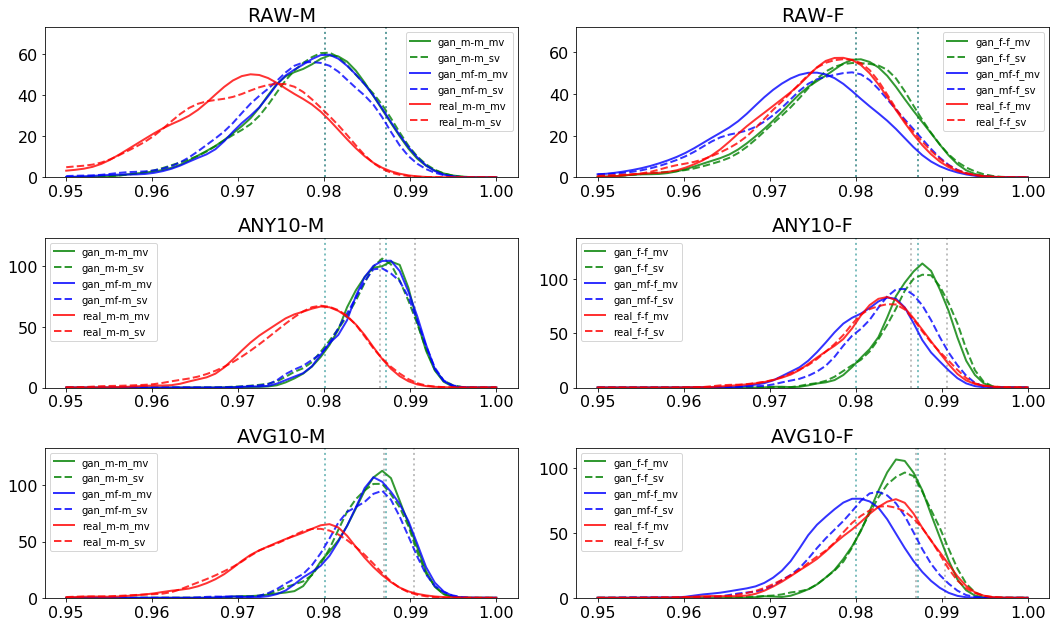

In [30]:
plt.figure(figsize=(15, 9))
plt.rcParams.update({'font.size': 16,'legend.fontsize': 10, 'legend.handlelength': 2})

plot_counter = 1
for policy in ['raw', 'any10', 'avg10']:
    thr_eer = results[policy]['eer']['thr']
    thr_far1 = results[policy]['far1']['thr']
    raw_thr_eer = results['raw']['eer']['thr']
    raw_thr_far1 = results['raw']['far1']['thr']
    for gender in ['-m_', '-f_']:
        imp_sets = [file for file in scores.keys() if policy in file and gender in file]
        imp_sets.sort()
        plt.subplot(3,2,plot_counter)
        plt.axvline(x=thr_eer, linewidth=2, linestyle=':', color='grey', alpha=0.5)
        plt.axvline(x=thr_far1, linewidth=2, linestyle=':', color='grey', alpha=0.5)
        plt.axvline(x=raw_thr_eer, linewidth=2, linestyle=':', color='teal', alpha=0.5)
        plt.axvline(x=raw_thr_far1, linewidth=2, linestyle=':', color='teal', alpha=0.5)
        plt.title(policy.upper() + '-' + gender.upper()[1:-1])
        for imp_index, imp_set in enumerate(imp_sets):
            label = imp_set.replace('_' + imp_set.split('_')[-1],'')
            values = scores[imp_set][gender[1:-1]]
                #values += scores[imp_set][s][gender[1:-1]]
            distrib = np.array(values)
            density = stats.gaussian_kde(distrib)
            n, x, _ = plt.hist(distrib, bins=np.linspace(0.95, 1.0), histtype=u'step', density=True, alpha=0.0)  
            plt.plot(x, density(x), lw=2, color=colors[label], label=label, linestyle=(styles[0] if '_mv_' in imp_set else styles[1]), alpha=0.8)
        plt.legend()
        plot_counter += 1
plt.tight_layout()
plt.savefig('scores_user_imp_results' + model_id +'.png', bbox_inches='tight')
plt.show()

### Learning Progress

In [31]:
sets = ['progress-fgan_f', 'progress-mgan_m', 'progress-mfgan_f', 'progress-mfgan_m']

In [32]:
histories = {}
for s in sets:
    histories[s] = load_obj(os.path.join('./dl_master_voices/sets/', s, 'training_history'))

Loading object ./dl_master_voices/sets/progress-fgan_f/training_history
Loading object ./dl_master_voices/sets/progress-mgan_m/training_history
Loading object ./dl_master_voices/sets/progress-mfgan_f/training_history
Loading object ./dl_master_voices/sets/progress-mfgan_m/training_history


In [33]:
colors = {'progress-fgan_f': 'r', 
          'progress-mfgan_f': 'g',
          'progress-mgan_m': 'r', 
          'progress-mfgan_m': 'g'}

3
3
2
3


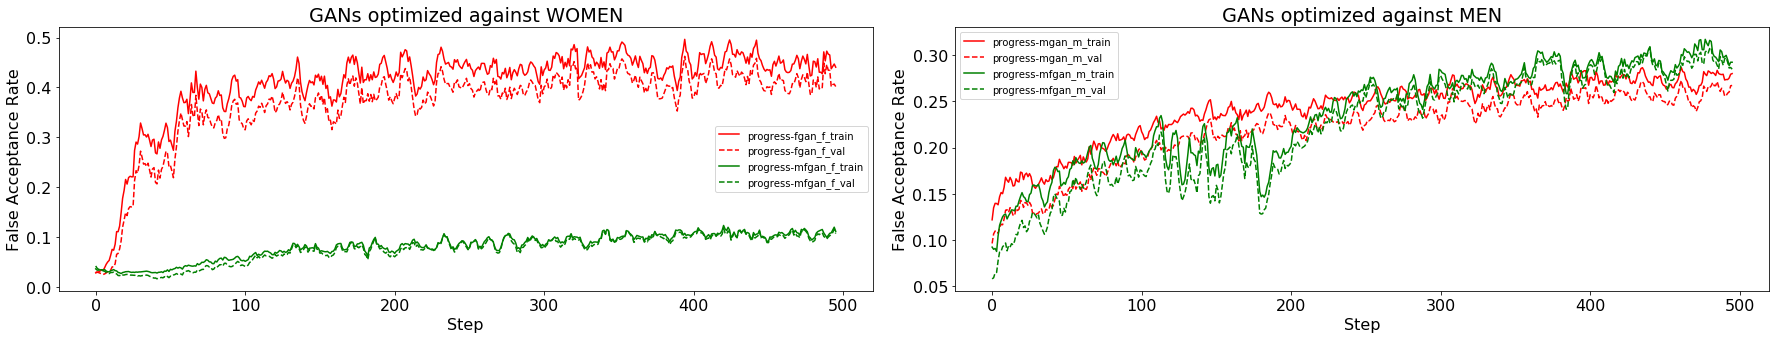

In [42]:
plt.figure(figsize=(25, 5))
n_iterations = 496
max_attempts = 1
for index, (subset, gender) in enumerate(zip([['progress-fgan_f', 'progress-mfgan_f'],['progress-mgan_m', 'progress-mfgan_m']], ['WOMEN', 'MEN'])):
    plt.subplot(1,2,index+1)
    plt.xlabel('Step')
    plt.ylabel('False Acceptance Rate')
    plt.title('GANs optimized against ' + gender)
    for s in subset:
        name = s.split('-')[-1]
        n_attempts = len(list(histories[s].keys()))
        print(n_attempts)
        fac_values = []
        test_fac_values = []
        for i, a in enumerate(list(histories[s].keys())[:max_attempts]):
            fac_values.append(histories[s][a]['fac_values_1'])
            test_fac_values.append(histories[s][a]['test_fac_values_1'])
        plt.plot(list(range(0,n_iterations)), moving_average(np.mean(np.array(fac_values), axis=0) / 22500), color=colors[s], label=s + '_' + 'train')
        plt.plot(list(range(0,n_iterations)), moving_average(np.mean(np.array(test_fac_values), axis=0) / 2500), color=colors[s], linestyle='--', label=s + '_' + 'val')
    plt.legend()

plt.tight_layout()
plt.savefig('eer_learning_progress.png')
plt.show()

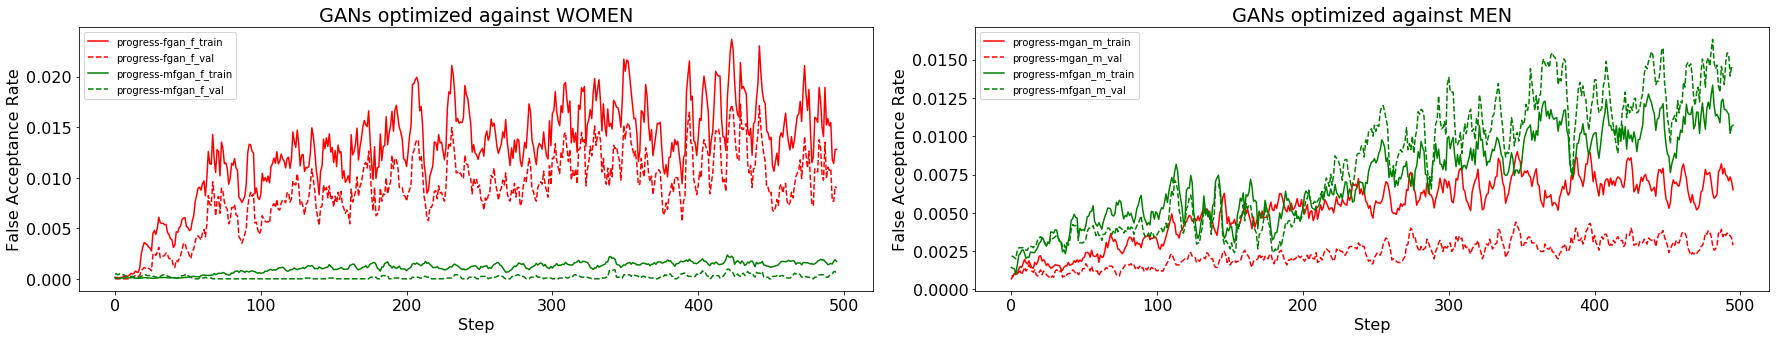

In [40]:
plt.figure(figsize=(25, 5))
n_iterations = 496
for index, (subset, gender) in enumerate(zip([['progress-fgan_f', 'progress-mfgan_f'],['progress-mgan_m', 'progress-mfgan_m']], ['WOMEN', 'MEN'])):
    plt.subplot(1,2,index+1)
    plt.xlabel('Step')
    plt.ylabel('False Acceptance Rate')
    plt.title('GANs optimized against ' + gender)
    for s in subset:
        name = s.split('-')[-1]
        n_attempts = len(list(histories[s].keys()))
        fac_values = []
        test_fac_values = []
        for i, a in enumerate(list(histories[s].keys())[:max_attempts]):
            fac_values.append(histories[s][a]['fac_values_2'])
            test_fac_values.append(histories[s][a]['test_fac_values_2'])
        plt.plot(list(range(0,n_iterations)), moving_average(np.mean(np.array(fac_values), axis=0) / 22500), color=colors[s], label=s + '_' + 'train')
        plt.plot(list(range(0,n_iterations)), moving_average(np.mean(np.array(test_fac_values), axis=0) / 2500), color=colors[s], linestyle='--', label=s + '_' + 'val')
    plt.legend()

plt.tight_layout()
plt.savefig('far1_learning_progress.png')
plt.show()